In [47]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import numpy as np
import seaborn as sns
import string

import nltk
from nltk import word_tokenize
from nltk.tag import pos_tag, map_tag
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import cross_val_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

In [48]:
# SW 1,2,4 en train
dfSW1_droid = pd.read_csv('trainReplicasSW1_droid.csv',sep='/',converters={"replica":str,"isDroid":int})
dfSW1_nonDroid = pd.read_csv('trainReplicasSW1_nonDroid.csv',sep='/',converters={"replica":str,"isDroid":int})
dfSW2_droid = pd.read_csv('trainReplicasSW2_droid.csv',sep='/',converters={"replica":str,"isDroid":int})
dfSW2_nonDroid = pd.read_csv('trainReplicasSW2_nonDroid.csv',sep='/',converters={"replica":str,"isDroid":int})
dfSW3_droid = pd.read_csv('trainReplicasSW3_droid.csv',sep='/',converters={"replica":str,"isDroid":int})
dfSW3_nonDroid = pd.read_csv('trainReplicasSW3_nonDroid.csv',sep='/',converters={"replica":str,"isDroid":int})
dfSW4_droid = pd.read_csv('trainReplicasSW4_droid.csv',sep='/',converters={"replica":str,"isDroid":int})
dfSW4_nonDroid = pd.read_csv('trainReplicasSW4_nonDroid.csv',sep='/',converters={"replica":str,"isDroid":int})

In [49]:
trainArray = [dfSW1_droid,dfSW1_nonDroid,dfSW2_droid,dfSW2_nonDroid,dfSW3_droid,dfSW3_nonDroid,dfSW4_droid,dfSW4_nonDroid]
trainFrame = pd.concat(trainArray)

# Remove ponctuation (for postag and lemm. functions)

In [50]:
def getRidOfPunctuation(sentence):
    sentence = sentence.translate(str.maketrans('','', string.punctuation))
    return(sentence)

# Création d'une colonne des répliques lemmatized

In [51]:
wnl = WordNetLemmatizer()

def getLemmatizedSentenceFromRow(rawSentenceRow):
    rawSentence = rawSentenceRow['replica']
    lemmatizedList = [wnl.lemmatize(i,j[0].lower()) if j[0].lower() in ['a','n','v'] else wnl.lemmatize(i) for i,j in pos_tag(word_tokenize(rawSentence))]
    lemmatizedSentence = " ".join(lemmatizedList)
    return(getRidOfPunctuation(lemmatizedSentence))
    
def addLemmatizedSentencesColumnToDF(rawTextDF):
    rawTextDF['lemmatizedSentences'] = rawTextDF.apply(lambda row: getLemmatizedSentenceFromRow(row),axis=1)
    return(rawTextDF)

In [52]:
trainFrame
trainFrame = addLemmatizedSentencesColumnToDF(trainFrame)
trainFrame

,replica,isDroid,lemmatizedSentences
0,"I'm TC-14 at your service. This way, please.",1,I m TC14 at your service This way please
1,"We are greatly honored by your visit, Ambassad...",1,We be greatly honor by your visit Ambassadors...
2,Cease fire.,1,Cease fire
3,"Master Anakin, you are my maker and I wish you...",1,Master Anakin you be my maker and I wish you ...
4,"However, I should prefer it if I were a little...",1,However I should prefer it if I be a little m...
5,Sell me?,1,Sell me
6,My troops are in position to begin searching t...,1,My troop be in position to begin search the sw...
7,"Yes, sir.",1,Yes sir
8,"Captain, take them to Camp 4.",1,Captain take them to Camp 4
9,"Roger, roger.",1,Roger roger


# Création d'une colonne de POS Tag

https://stackoverflow.com/questions/5787673/python-nltk-how-to-tag-sentences-with-the-simplified-set-of-part-of-speech-tags

In [53]:
exampleSentence = dfSW1_droid['replica'][0]

text = nltk.word_tokenize(exampleSentence)
print(text)
posTagged = pos_tag(text)
simplifiedTags = [(word, map_tag('en-ptb', 'universal', tag)) for word, tag in posTagged]
type(simplifiedTags)

tagSentence = []
for posTag in simplifiedTags:
    tagSentence.append(posTag[1])
tagSentence = " ".join(tagSentence)
print(tagSentence)

['I', "'m", 'TC-14', 'at', 'your', 'service', '.', 'This', 'way', ',', 'please', '.']
PRON VERB ADJ ADP PRON NOUN . DET NOUN . NOUN .


In [54]:
def getPosTagSentenceFromRow(rawSentenceRow):
    rawSentence = rawSentenceRow['replica']
    tokenizedRaw = nltk.word_tokenize(rawSentence)
    posTaggedRaw = pos_tag(tokenizedRaw)
    simplifiedTags = [(word, map_tag('en-ptb', 'universal', tag)) for word, tag in posTaggedRaw]
    tagSentenceList = []
    for posTag in simplifiedTags:
        tagSentenceList.append(posTag[1])
    tagSentence = " ".join(tagSentenceList)
    return(getRidOfPunctuation(tagSentence))

def addPosTagSentencesColumnToDF(rawTextDF):
    rawTextDF['posTaggedSentences'] = rawTextDF.apply(lambda row: getPosTagSentenceFromRow(row),axis=1)
    return(rawTextDF)

In [55]:
trainFrame = addPosTagSentencesColumnToDF(trainFrame)
trainFrame

,replica,isDroid,lemmatizedSentences,posTaggedSentences
0,"I'm TC-14 at your service. This way, please.",1,I m TC14 at your service This way please,PRON VERB ADJ ADP PRON NOUN . DET NOUN . NOUN .
1,"We are greatly honored by your visit, Ambassad...",1,We be greatly honor by your visit Ambassadors...,PRON VERB ADV VERB ADP PRON NOUN . NOUN . NOUN...
2,Cease fire.,1,Cease fire,NOUN NOUN .
3,"Master Anakin, you are my maker and I wish you...",1,Master Anakin you be my maker and I wish you ...,NOUN NOUN . PRON VERB PRON NOUN CONJ PRON VERB...
4,"However, I should prefer it if I were a little...",1,However I should prefer it if I be a little m...,ADV . PRON VERB VERB PRON ADP PRON VERB DET AD...
5,Sell me?,1,Sell me,VERB PRON .
6,My troops are in position to begin searching t...,1,My troop be in position to begin search the sw...,PRON NOUN VERB ADP NOUN PRT VERB VERB DET NOUN...
7,"Yes, sir.",1,Yes sir,X . NOUN .
8,"Captain, take them to Camp 4.",1,Captain take them to Camp 4,NOUN . VERB PRON PRT NOUN NUM .
9,"Roger, roger.",1,Roger roger,NOUN . NOUN .


# Création de la matrice de features répliques + posTagged répliques

In [27]:
tfidfRaw = TfidfVectorizer(sublinear_tf=True, min_df=1, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
tfidfPosTags = TfidfVectorizer(sublinear_tf=True, min_df=1, norm='l2', encoding='latin-1', ngram_range=(1, 2))

features1 = tfidfRaw.fit_transform(trainFrame.lemmatizedSentences).toarray()
features2 = tfidfPosTags.fit_transform(trainFrame.posTaggedSentences).toarray()
labels = trainFrame.isDroid

print((features1 > 0.5).sum())
print((features2 > 0.5).sum())
print(type(features1))

228
138
<class 'numpy.ndarray'>


# Naive Bayes Classifier

In [28]:
print(features1.shape)
print(features2.shape)
features = np.concatenate((features1,features2),axis=1)
print(features.shape)

X_train = features
y_train = np.array(trainFrame['isDroid'])

clf = MultinomialNB().fit(features, y_train)

(376, 1865)
(376, 96)
(376, 1961)


# Model selection

as suggested on https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

In [29]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(class_prior=[0.5,0.5]),
    LogisticRegression(random_state=0),
]

CV = 3
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
      entries.append((model_name, fold_idx, accuracy))
        
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

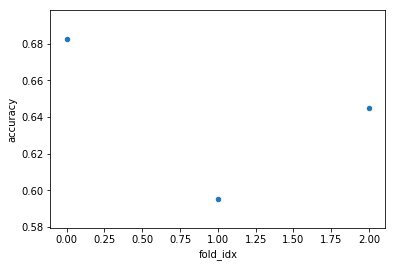

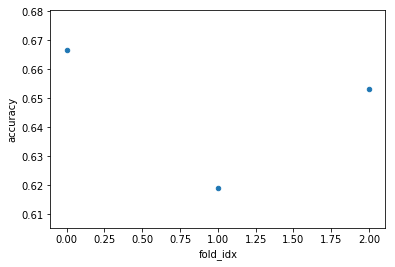

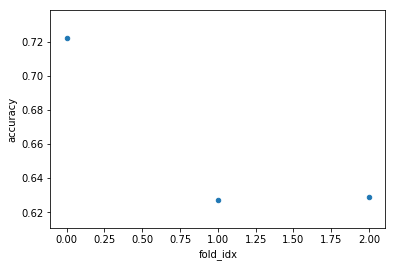

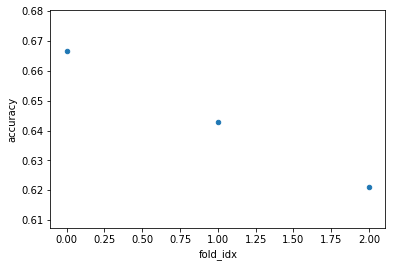

In [30]:
cv_df_RF = cv_df.loc[cv_df['model_name']=='RandomForestClassifier']
cv_df_RF.plot(x='fold_idx',y='accuracy',kind="scatter")

cv_df_LinearSVC = cv_df.loc[cv_df['model_name']=='LinearSVC']
cv_df_LinearSVC.plot(x='fold_idx',y='accuracy',kind="scatter")

cv_df_MultinomNB = cv_df.loc[cv_df['model_name']=='MultinomialNB']
cv_df_MultinomNB.plot(x='fold_idx',y='accuracy',kind="scatter")

cv_df_LogReg = cv_df.loc[cv_df['model_name']=='LogisticRegression']
cv_df_LogReg.plot(x='fold_idx',y='accuracy',kind="scatter")